In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Basic data manipulation
import numpy as np
import pandas as pd

# Embeddings and basic machine learning
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

# Plotting gear
import matplotlib.pyplot as plt
import seaborn as sns

# DeepOF
import deepof.data

# DLS
from DLS_utils import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### DLS annotation analysis

### 1. Load, format and merge data per domain

In [4]:
# Load maze reuslts
epm = pd.read_excel("../DLS_data/External_tables/EPM_Y_maze/DLS Experiment EPM.xlsx").iloc[:44]
ymaze = pd.read_excel("../DLS_data/External_tables/EPM_Y_maze/DLS Experiment Y Maze.xlsx")[:43]
mazes = pd.merge(epm, ymaze, on="Animal", how="inner", suffixes=("_epm", "_ymaze"))
mazes.drop([col for col in mazes.columns if "treat" in col], axis=1, inplace=True)

# Load HCA results
hca_results = pd.read_csv("../DLS_data/External_tables/MASTERFILE_DLS_HCA_final.csv", sep=";", decimal=",").iloc[:, :11]
hca_results = hca_results.rename(columns={"ID": "Sample name"})
hca_results["Sample name"] = hca_results["Sample name"].astype(int)
hca_results["Condition"] = hca_results["Condition"].replace({"gestresst": "CSDS", "ungestresst": "Control"})

# Load IL6 results
il6_results = pd.read_csv("../DLS_data/External_tables/IL-6 concentrations DLS_final table.csv", sep=";", header=1, decimal=",")
il6_results = il6_results.rename(columns={"DLS ID": "Sample name", "Group": "Condition"})
il6_results["Condition"] = il6_results["Condition"].replace({"gestresst": "CSDS", "ungestresst": "Control"})

# NOR results
nor_results = pd.read_csv("../DLS_data/External_tables/Iven NOR.csv", sep=";", decimal=",")
nor_results["Condition"] = nor_results["Condition"].replace({"gestresst": "CSDS", "ungestresst": "Control"})

# Load cort reults
cort_sucrose_results = pd.ExcelFile('../DLS_data/External_tables/Weight_Fur_Adrenals_CORT_SPT_FUST_NEst_buiding/CSD_BL6_n=44_(28 CSD_16 CTRL)_01.12-22.xlsx')
cort = pd.read_excel(cort_sucrose_results, 'CORT basline TERMINAl').drop("Treatment", axis=1)
cort["Condition"] = cort["Condition"].replace({"gestresst": "CSDS", "ungestresst": "Control"})

# Sucrose preference results
sucrose = pd.read_excel(cort_sucrose_results, 'Sucrose_preference')
sucrose["Condition"] = sucrose["Condition"].replace({"gestresst": "CSDS", "ungestresst": "Control"})
sucrose.rename(columns={"CSD ": "Sample name"}, inplace=True)

In [5]:
# Load remaining external reuslts
extra_params = pd.ExcelFile('../DLS_data/External_tables/Weight_Fur_Adrenals_CORT_SPT_FUST_NEst_buiding/CSD_BL6_n=44_(28 CSD_16 CTRL)_01.12-22.12_DLS_Confirmation_Experiments_concise.xlsx')
weight_fur = pd.read_excel(extra_params, "Weight - Fur")
cort_initial = pd.read_excel(extra_params, "CORT basline TERMINAl")
cort_initial["Condition"] = cort_initial["Condition"].replace({"gestresst": "CSDS", "ungestresst": "Control"})
urine_sniffing = pd.read_excel(extra_params, "Urine sniffing test")
urine_sniffing["Condition"] = urine_sniffing["Condition"].replace({"gestresst": "CSDS", "ungestresst": "Control"})
nest_building = pd.read_excel(extra_params, "Nest building")
nest_building["Condition"] = nest_building["Condition"].replace({"gestresst": "CSDS", "ungestresst": "Control"})

merged_dataset = weight_fur.rename(columns={"CSD weight ": "Sample name"})
merged_dataset["Sample name"] = merged_dataset["Sample name"].astype("int64")

suffixes = ["_weight", "_cort_initial", "_cort", "_nest_building", "_urine_sniffing", "_hca", "_il6", "_nor"]
for i, dataset in enumerate([cort_initial, cort, nest_building, urine_sniffing, hca_results, il6_results, nor_results]):
    dataset["Sample name"] = dataset["Sample name"].astype("int64")
    merged_dataset = pd.merge(merged_dataset, dataset, how="outer", on=["Sample name", "Condition"], suffixes=suffixes[i:i+2])
merged_dataset = merged_dataset.drop_duplicates(subset=["Sample name", "Condition"]).iloc[:-1]

In [6]:
# Load DeepOF OF (single housing) results

# Global aggregated supervised and unsupervised annotations
deepof_of_labels = pd.read_csv("../DLS_data/DeepOF/OF/DLS_labels.csv")
deepof_of_supervised_annotations = pd.read_csv("../DLS_data/DeepOF/OF/DLS_OF_project/Output/DLS_OF_labels.csv")
deepof_of_supervised_annotations_aggregated = pd.read_csv("../DLS_data/DeepOF/OF/DLS_OF_project/Output/DLS_OF_labels_aggregated.csv")
deepof_of_supervised_annotations_aggregated["Condition"] = deepof_of_supervised_annotations_aggregated["CSDS"].replace({"Stressed": "CSDS"})
deepof_of_supervised_annotations_aggregated["Sample name"] = deepof_of_supervised_annotations_aggregated["ID"].str.split("_").str[0].str.replace("ID", "").astype(int)
deepof_of_supervised_annotations_aggregated["Session"] = deepof_of_supervised_annotations_aggregated["ID"].str[-1].astype(int)

deepof_of_unsupervised_total_cluster_changes = pd.read_csv("../DLS_data/DeepOF/OF/DLS_OF_project/Output/OF_total_cluster_changes.csv")
deepof_of_unsupervised_total_cluster_changes["Condition"] = deepof_of_unsupervised_total_cluster_changes["CSDS"].replace({"Stressed": "CSDS"})
deepof_of_unsupervised_total_cluster_changes["Sample name"] = deepof_of_unsupervised_total_cluster_changes["AID"].str.split("_").str[0].str.replace("ID", "").astype(int)

deepof_of_unsupervised_entropy_scores = pd.read_csv("../DLS_data/DeepOF/OF/DLS_OF_project/Output/OF_entropy_scores.csv")

# Time-resolved annotations per session
deepof_of_S_both_in_center_data = pd.read_csv("../DLS_data/DeepOF/OF/DLS_OF_project/Output/OF_Session=both_in_center_data.csv")
deepof_of_S1_in_center_data = pd.read_csv("../DLS_data/DeepOF/OF/DLS_OF_project/Output/OF_Session=1_in_center_data.csv")
deepof_of_S2_in_center_data = pd.read_csv("../DLS_data/DeepOF/OF/DLS_OF_project/Output/OF_Session=2_in_center_data.csv")

# Time-resolved annotations per condition
deepof_of_C_both_in_center_data = pd.read_csv("../DLS_data/DeepOF/OF/DLS_OF_project/Output/OF_CSDS=both_in_center_data.csv")
deepof_of_C_control_in_center_data = pd.read_csv("../DLS_data/DeepOF/OF/DLS_OF_project/Output/OF_CSDS=Control_in_center_data.csv")
deepof_of_C_stressed_in_center_data = pd.read_csv("../DLS_data/DeepOF/OF/DLS_OF_project/Output/OF_CSDS=Stressed_in_center_data.csv")

In [7]:
# Load DeepOF SI (social interaction) results

# Global aggregated supervised and unsupervised annotations
deepof_si_labels = pd.read_csv("../DLS_data/DeepOF/SI/DLS_labels.csv")
deepof_si_supervised_annotations = pd.read_csv("../DLS_data/DeepOF/SI/DLS_SI_project/Output/DLS_SI_labels.csv")
deepof_si_supervised_annotations_aggregated = pd.read_csv("../DLS_data/DeepOF/SI/DLS_SI_project/Output/DLS_SI_labels_aggregated.csv")
deepof_si_supervised_annotations_aggregated["Condition"] = deepof_si_supervised_annotations_aggregated["CSDS"].replace({"Stressed": "CSDS"})
deepof_si_supervised_annotations_aggregated["Sample name"] = deepof_si_supervised_annotations_aggregated["ID"].str.split("_").str[0].str.replace("ID", "").astype(int)
deepof_si_supervised_annotations_aggregated["Session"] = deepof_si_supervised_annotations_aggregated["ID"].str[-1].astype(int)

deepof_si_stability_scores = pd.read_csv("/Users/lucasmiranda/PycharmProjects/DLS/DLS_data/DeepOF/SI/DLS_SI_project/Output/DLS_SI_social_stability.csv")
deepof_si_unsupervised_total_cluster_changes = pd.read_csv("../DLS_data/DeepOF/SI/DLS_SI_project/Output/SI_total_cluster_changes.csv")
deepof_si_unsupervised_total_cluster_changes["Condition"] = deepof_si_unsupervised_total_cluster_changes["CSDS"].replace({"Stressed": "CSDS"})
deepof_si_unsupervised_total_cluster_changes["Sample name"] = deepof_si_unsupervised_total_cluster_changes["AID"].str.split("_").str[0].str.replace("ID", "").astype(int)

deepof_si_unsupervised_entropy_scores = pd.read_csv("../DLS_data/DeepOF/SI/DLS_SI_project/Output/SI_entropy_scores.csv")

# Time-resolved annotations per session
deepof_si_S_both_in_center_data = pd.read_csv("../DLS_data/DeepOF/SI/DLS_SI_project/Output/SI_B6_CSDS_Session=both_in_center_data.csv")
deepof_si_S1_in_center_data = pd.read_csv("../DLS_data/DeepOF/SI/DLS_SI_project/Output/SI_B6_CSDS_Session1_in_center_data.csv")
deepof_si_S2_in_center_data = pd.read_csv("../DLS_data/DeepOF/SI/DLS_SI_project/Output/SI_B6_CSDS_Session2_in_center_data.csv")

# Time-resolved annotations per condition
deepof_si_C_both_in_center_data = pd.read_csv("../DLS_data/DeepOF/SI/DLS_SI_project/Output/SI_B6_Session_CSDS=both_in_center_data.csv")
deepof_si_C_control_in_center_data = pd.read_csv("../DLS_data/DeepOF/SI/DLS_SI_project/Output/SI_B6_CSDS_Control_in_center_data.csv")
deepof_si_C_stressed_in_center_data = pd.read_csv("../DLS_data/DeepOF/SI/DLS_SI_project/Output/SI_B6_CSDS_Stressed_in_center_data.csv")

##### 1.1 Loss of interest or pleasure (anhedonia) 

In [8]:
# AGS
ags_score = deepof_si_supervised_annotations_aggregated.loc[:, ["Sample name", "Session", "Condition", "B_W_nose2tail"]].sort_values(by=["Sample name", "Session"])
ags = pd.merge(
    ags_score.loc[ags_score.Session == 1].sort_values(by="Sample name").rename(columns={"B_W_nose2tail": "AGS_S1"}).drop("Session", axis=1),
    ags_score.loc[ags_score.Session == 2].sort_values(by="Sample name").rename(columns={"B_W_nose2tail": "AGS_S2"}).drop("Session", axis=1)
)

Criterion_1 = pd.merge(
    ags, # AGS
    urine_sniffing, # FUST
    how="inner",
    on=["Sample name", "Condition"],
)

Criterion_1 = pd.merge(
    Criterion_1,
    sucrose.drop([col for col in sucrose if "norm" in col], axis=1), # SPT
    how="inner",
    on=["Sample name", "Condition"],
)

##### 1.2 Significant appetite or body weight change 

In [9]:
Criterion_2 = merged_dataset.loc[:, 
[
    "Sample name",
    "Condition",
    "day 1 (1.12)",
    "day 5",
    "day 9",
    "day 13",
    "day 17",
    "day 21",
    "terminal d 22",
    ]
]

##### 1.3 Psychomotoric agitation or retardation

In [10]:
# Total cluster changes in OF (single animal)
cluster_changes_of = deepof_of_unsupervised_total_cluster_changes.loc[
    deepof_of_unsupervised_total_cluster_changes.Session == "First", ["Sample name", "Condition", "Total_cluster_changes"]
].rename(columns={"Total_cluster_changes": "Total_cluster_changes_OF_S1"}).sort_values(by="Sample name")
cluster_changes_of = pd.merge(cluster_changes_of, deepof_of_unsupervised_total_cluster_changes.loc[
    deepof_of_unsupervised_total_cluster_changes.Session == "Second", ["Sample name", "Condition", "Total_cluster_changes"]
].sort_values(by="Sample name"), on=["Sample name", "Condition"]).rename(columns={"Total_cluster_changes": "Total_cluster_changes_OF_S2"})

In [11]:
# Total cluster changes in SI (social interaction)
cluster_changes_si = deepof_si_unsupervised_total_cluster_changes.loc[
    deepof_si_unsupervised_total_cluster_changes.Session == "First", ["Sample name", "Condition", "Total_cluster_changes"]
].rename(columns={"Total_cluster_changes": "Total_cluster_changes_SI_S1"}).sort_values(by="Sample name")
cluster_changes_si = pd.merge(cluster_changes_si, deepof_si_unsupervised_total_cluster_changes.loc[
    deepof_si_unsupervised_total_cluster_changes.Session == "Second", ["Sample name", "Condition", "Total_cluster_changes"]
].sort_values(by="Sample name"), on=["Sample name", "Condition"]).rename(columns={"Total_cluster_changes": "Total_cluster_changes_SI_S2"})

In [12]:
# Mazes: EPM and Y-maze
mazes_psychomotorics = mazes.loc[:, [
    "Animal", 
    "Distance total_epm",
    "Mean speed total_epm", 
    "Closed arms : average speed", 
    "Open arms : distance_epm", 
    "Open arms : average speed_epm", 
    "Center : distance_epm",
    "Center : average speed_epm", 
    "Distance total_ymaze", 
    "Mean speed total_ymaze", 
    "Open arms : distance_ymaze", 
    "Open arms : average speed_ymaze", 
    "Center : distance_ymaze", 
    "Center : average speed_ymaze", 
    "Closed arm : distance",
    "Closed arm : average speed"
    ]].rename(columns={"Animal": "Sample name"})

In [13]:
# Average locomotion speed in OF (single animal)
OFT_speed = deepof_of_supervised_annotations_aggregated.loc[
    deepof_of_supervised_annotations_aggregated.Session == 1, ["Sample name", "Condition", "speed"]
].sort_values(by="Sample name").rename(columns={"speed": "Mean speed OF_S1"})

OFT_speed = pd.merge(
    OFT_speed,
    deepof_of_supervised_annotations_aggregated.loc[
        deepof_of_supervised_annotations_aggregated.Session == 2, ["Sample name", "Condition", "speed"]
    ].sort_values(by="Sample name").rename(columns={"speed": "Mean speed OF_S2"}),
    on=["Sample name", "Condition"]
)

In [14]:
Criterion_3 = pd.merge(
    cluster_changes_of,
    cluster_changes_si,
)
Criterion_3 = pd.merge(
    Criterion_3,
    mazes_psychomotorics,
)
Criterion_3 = pd.merge(
    Criterion_3,
    OFT_speed,
)

##### 1.4 Diminished ability to think or concentrate, or indecisiveness

In [15]:
# Y-maze results
mazes_concentration = mazes.loc[
    :, [
        "Animal",
        "Closed arm : entries",
        "Closed arm : time",
    ]
].rename(columns={"Animal": "Sample name"})

In [16]:
# NORT results
NORT_results = merged_dataset.loc[
    :, [
        "Sample name",
        "Condition",
        "frequencies novel object",
        "frequencies other object",
        "latencies 1st novel object",
        "latencie other object",
        "time novel object",
        "time other object",
    ]
]

In [17]:
Criterion_4 = pd.merge(
    mazes_concentration,
    NORT_results,
).sort_values("Sample name")

##### 1.5 Fatigue or loss of energy

In [18]:
Criterion_5 = merged_dataset.loc[
    :, [
        "Sample name",
        "Condition",
        "nual score after overnight HCA",
        "DISTANCE (m)",
        "Center.raw.speed",
        "Center.speed.moving",
        "Fur day 1 (1.12)",
        "Fur day 5",
        "Fur day 9",
        "Fur day 13",
        "Fur day 17",
        "Fur day 21",
        "Fur terminal ",
    ]
]

##### 1.6 Anxiety

In [19]:
Criterion_6 = mazes.loc[
    :, [
        "Animal",
        "Open arms : entries",
        "Open arms : time_epm",
    ]
].rename(columns={"Animal": "Sample name"})

In [20]:
# Center entries in OF (single animal)
OFT_center_entries = deepof_of_supervised_annotations_aggregated.loc[
    deepof_of_supervised_annotations_aggregated.Session == 1, ["Sample name", "Condition", "Center_entries", "In_center"]
].sort_values(by="Sample name").rename(columns={"In_center": "In_center_OF_S1", "Center_entries": "Center_entries_OF_S1"})

OFT_center_entries = pd.merge(
    OFT_center_entries,
    deepof_of_supervised_annotations_aggregated.loc[
        deepof_of_supervised_annotations_aggregated.Session == 2, ["Sample name", "Condition", "Center_entries", "In_center"]
    ].sort_values(by="Sample name").rename(columns={"In_center": "In_center_OF_S2", "Center_entries": "Center_entries_OF_S2"}),
    on=["Sample name", "Condition"],
)

In [21]:
# Center entries in SI (social interaction)
SIT_center_entries = deepof_si_supervised_annotations_aggregated.loc[
    deepof_si_supervised_annotations_aggregated.Session == 1, ["Sample name", "Condition", "B_center_entries", "B_in_center"]
].sort_values(by="Sample name").rename(columns={"B_in_center": "In_center_SI_S1", "B_center_entries": "Center_entries_SI_S1"})

SIT_center_entries = pd.merge(
    SIT_center_entries,
    deepof_si_supervised_annotations_aggregated.loc[
        deepof_si_supervised_annotations_aggregated.Session == 2, ["Sample name", "Condition", "B_center_entries", "B_in_center"]
    ].sort_values(by="Sample name").rename(columns={"B_in_center": "In_center_SI_S2", "B_center_entries": "Center_entries_SI_S2"}),
    on=["Sample name", "Condition"],
)

In [22]:
Criterion_6 = pd.merge(
    Criterion_6,
    OFT_center_entries,
    on=["Sample name"]
)
Criterion_6 = pd.merge(
    Criterion_6,
    SIT_center_entries,
    on=["Sample name", "Condition"]
).sort_values("Sample name")

##### 1.7 Core biological features

In [23]:
Criterion_7 = merged_dataset.loc[
    :, [
        "Sample name",
        "Condition",
        "[(Adrenal 1+2 [mg])/2)*1000]/BW terminal [g]",
        "Concentration [nmol/L]_cort_initial",
        "Concentration [ng/ml]_cort_initial",
        "Concentration [nmol/L]_cort",
        "Concentration [ng/ml]_cort",
        "IL-6 concentration (pg/ml)",
    ]
]

##### 1.8 Socio-functional impairment and phenotype stability over time

In [24]:
deepof_si_stability_scores["Sample name"] = deepof_si_stability_scores["ID"].str.split("_").str[0].str.replace("ID", "").astype(int)
deepof_si_stability_scores.rename(columns={"CSDS": "Condition"}, inplace=True)
Criterion_8 = deepof_si_stability_scores.loc[
    :, [
        "Sample name", 
        "Condition", 
        "Aggregated Social Z-score over sessions", 
        "Average alteration stability (Session 2 - Session 1)"
        ]
    ].sort_values("Sample name")
Criterion_8.Condition = Criterion_8.Condition.map({"Stressed": "CSDS", "Control": "Control"})

##### Merge all domains into a single dataframe

In [25]:
# Save a list with all variables per domain, and merge all datasets for further processing
DLS_domain_variable_dict = {}
full_DLS_data = None

for domain, criterion in zip(
    [
        "Anhedonia",
        "Apetite / weight",
        "Psychomotor changes",
        "Lack of concentration",
        "Fatigue",
        "Anxiety",
        "Biological markers",
        "Socio-temporal functions",
        ],
    [Criterion_1, Criterion_2, Criterion_3, Criterion_4, Criterion_5, Criterion_6, Criterion_7, Criterion_8],
):
    # Get variables for the current DLS domain
    DLS_domain_variable_dict[domain] = [col for col in list(criterion.columns) if col not in ["Sample name", "Condition"]]
    criterion["Condition"] = criterion["Condition"].map({"CSDS": "DLS", "Control": "Control"})

    # Merge datasets
    if full_DLS_data is None:
        full_DLS_data = criterion
    else:
        full_DLS_data = pd.merge(full_DLS_data, criterion, on=["Sample name", "Condition"], how="outer")

# Save DLS variables
DLS_domain_variable_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in DLS_domain_variable_dict.items()]))
DLS_domain_variable_df = DLS_domain_variable_df.melt(var_name="DLS domain", value_name="Variable").dropna().reset_index(drop=True)
DLS_domain_variable_df.to_csv("../DLS_data/External_tables/DLS_variables_per_domain.csv")

# Save full DLS dataset
full_DLS_data.to_csv("../DLS_data/External_tables/DLS_profiling_unnormalized.csv")

### 2. Multivariate projections and DLS normative model

In [26]:
# Impute missing data
full_DLS_data.iloc[:, 2:] = StandardScaler().fit_transform(IterativeImputer().fit_transform(full_DLS_data.iloc[:, 2:]))
full_DLS_data.to_csv("../DLS_data/External_tables/DLS_profiling_normalized_imputed.csv")

[IterativeImputer] Early stopping criterion not reached.


In [27]:
pca = PCA(n_components=2).fit_transform(full_DLS_data.iloc[:, 2:])
pca_dataset = pd.DataFrame(
    {
        "ID": full_DLS_data["Sample name"],
        "condition": full_DLS_data["Condition"],
        "PC1": pca[:, 0],
        "PC2": pca[:, 1],
    }
).sort_values("condition", ascending=False)

In [28]:
# Build a basic normative model for non-stressed animals and compare scores
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

# Define the range of bandwidth values to search over
params = {'bandwidth': np.linspace(0.1, 10, 200)}

# Create an instance of the KernelDensity estimator
kde = KernelDensity(kernel='gaussian')

# Perform a grid search to find the optimal bandwidth value
grid_search = GridSearchCV(kde, params, cv=10)
grid_search.fit(pca[full_DLS_data.Condition == "Control", :])

# Print the optimal bandwidth value and the corresponding cross-validation score
print("Optimal bandwidth: {:.3f}".format(grid_search.best_params_['bandwidth']))
print("Log-likelihood score: {:.3f}".format(grid_search.best_score_))


Optimal bandwidth: 1.791
Log-likelihood score: -8.661


In [29]:
kd_estimation = KernelDensity(kernel='gaussian', bandwidth=grid_search.best_params_['bandwidth']).fit(
    pca[full_DLS_data.Condition == "Control", :]
)
norm_samples = kd_estimation.sample(1000)
pca_dataset["norm-scores"] = kd_estimation.score_samples(pca_dataset.loc[:, ["PC1", "PC2"]].values)
pca_dataset["norm-scores"] -= pca_dataset.loc[pca_dataset.condition == "Control", "norm-scores"].mean()

In [30]:
pca_dataset[["ID", "condition", "norm-scores"]].sort_values(["condition", "norm-scores"]).to_csv("../../../Desktop/DLS_norm_scores.csv")
pca_dataset = pca_dataset.sort_values("condition")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. DLS: Mann-Whitney-Wilcoxon test two-sided, P_val:2.131e-06 U_stat=4.410e+02


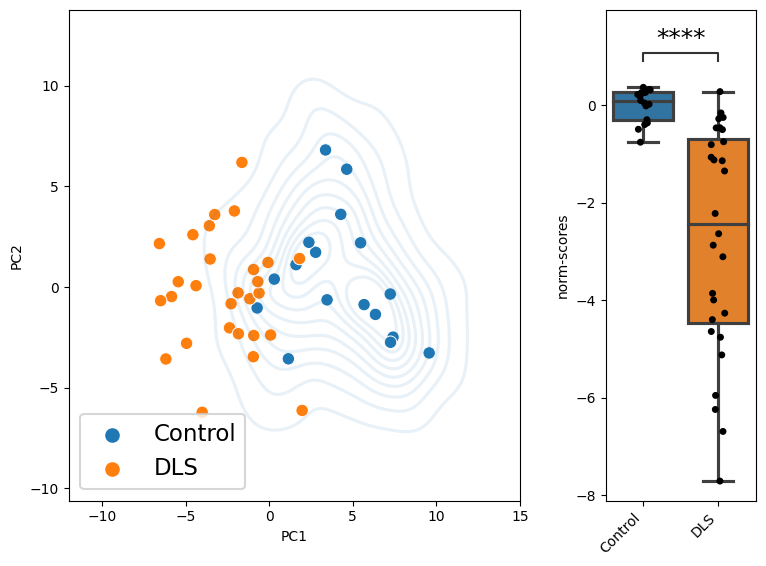

In [31]:
from statannotations.Annotator import Annotator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), gridspec_kw={'width_ratios': [3, 1]})

sns.set_context("talk")
sns.scatterplot(data=pca_dataset, x="PC1", y="PC2", hue="condition", ax=ax1)

sns.kdeplot(x=norm_samples[:, 0], y=norm_samples[:, 1], ax=ax1, alpha=0.1)
sns.boxplot(data=pca_dataset, x="condition", y="norm-scores", ax=ax2)
sns.stripplot(data=pca_dataset, x="condition", y="norm-scores", dodge=True, color="black", ax=ax2)

# Add statistical annotations
annotator = Annotator(
    pairs=[("DLS", "Control")],
    data=pca_dataset, 
    x="condition", 
    y="norm-scores", 
    ax=ax2
)
annotator.configure(
    test="Mann-Whitney",
)
annotator.apply_and_annotate()

ax1.legend(loc="lower left")
ax2.set_xlabel("")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
ax1.set_xlim(-12, 15)
plt.tight_layout()
plt.savefig("CSDS_multivariate_score.pdf")
plt.show()

### 3. Multivariate feature importance analysis

In [32]:
# Compute Z-scores per variable
z_bases = full_DLS_data.loc[full_DLS_data.Condition == "Control"].iloc[:, 2:].agg({"mean", "std"})
z_bases

,AGS_S1,AGS_S2,Urine sniffing (s) 0,interactions with urine 0,Urine sniffing (s) 1,interactions with urine 1,Sucrose preference session 1,Sucrose preference session 2,Sucrose preference total,day 1 (1.12),...,Center_entries_SI_S2,In_center_SI_S2,[(Adrenal 1+2 [mg])/2)*1000]/BW terminal [g],Concentration [nmol/L]_cort_initial,Concentration [ng/ml]_cort_initial,Concentration [nmol/L]_cort,Concentration [ng/ml]_cort,IL-6 concentration (pg/ml),Aggregated Social Z-score over sessions,Average alteration stability (Session 2 - Session 1)
mean,0.701532,0.825817,0.569489,0.568098,0.269791,0.485833,0.154276,-0.194659,-0.013482,0.169368,...,0.959376,0.866212,-0.876682,-0.103567,-0.103566,-0.103556,-0.103555,-0.350029,0.763897,-0.144464
std,0.813203,1.074347,1.442574,1.153512,1.124385,1.233748,0.786154,0.816022,0.809419,0.757700,...,0.874242,0.988513,0.673625,1.063603,1.063603,1.063604,1.063604,0.579795,0.725493,1.384049


In [33]:
z_scored = full_DLS_data.loc[
    full_DLS_data.Condition == "DLS"
].drop(["Sample name", "Condition"], axis=1).apply(
    lambda x: (x - z_bases.loc["mean", x.name]) / z_bases.loc["std", x.name]
).melt()

# Sort values per average deviation
sorted_vars = z_scored.groupby("variable").value.mean().sort_values(ascending=False).index
z_scored.index = z_scored.variable
z_scored = z_scored.loc[sorted_vars]

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


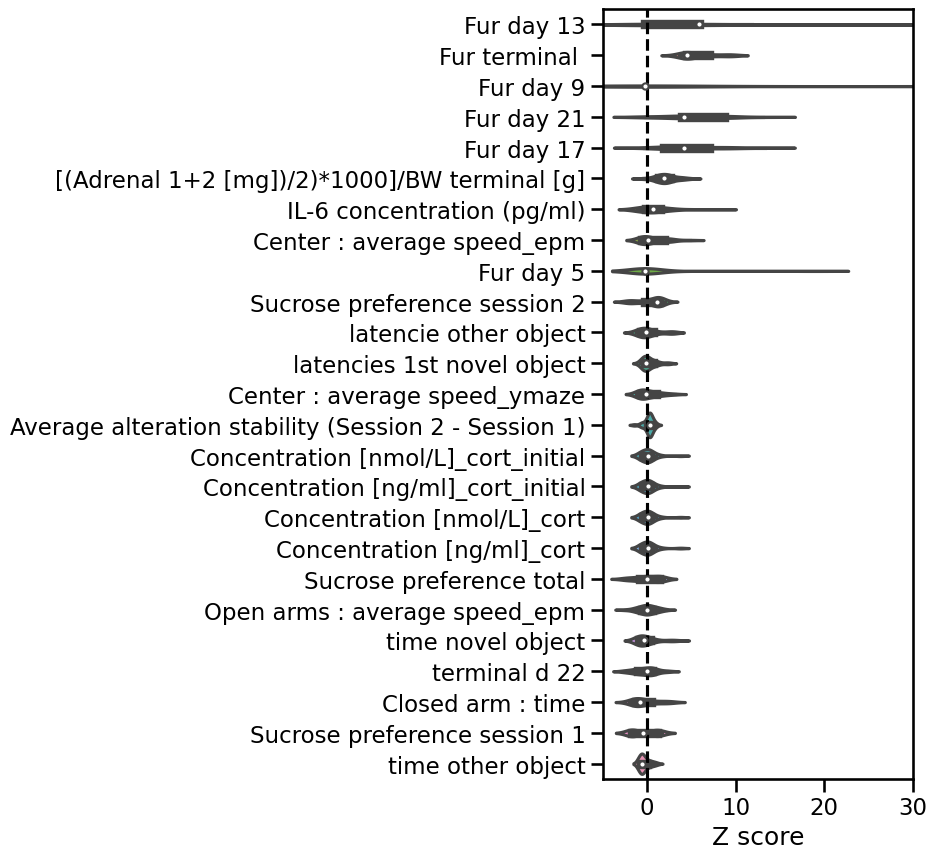

In [34]:
plt.figure(figsize=(4, 10), dpi=100)

sns.violinplot(
    data=z_scored.loc[sorted_vars[:25]],
    x="value",
    y="variable",
)
plt.axvline(0, color="black", linestyle="--")
plt.xlim(-5, 30)
plt.xlabel("Z score")
plt.ylabel("")
plt.tight_layout()
plt.savefig("Z_scores_top10.pdf", bbox_inches='tight')
plt.show()

### Integrate all data in scores per domain

In [56]:
# Compute full Z-score profiling per DLS domain
domain_scores = compute_domain_scores(full_DLS_data, DLS_domain_variable_dict)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Lack of concentration_Control vs. Lack of concentration_DLS: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.949e-02 U_stat=1.570e+02
Fatigue_Control vs. Fatigue_DLS: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.901e-07 U_stat=1.500e+01
DLS score_Control vs. DLS score_DLS: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.675e-07 U_stat=1.400e+01
Anxiety_Control vs. Anxiety_DLS: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.222e-06 U_stat=4.100e+01
Anhedonia_Control vs. Anhedonia_DLS: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.153e-06 U_stat=4.800e+01
Psychomotor changes_Control vs. Psychomotor changes_DLS: Mann-Whitney-Wilcoxon test two-

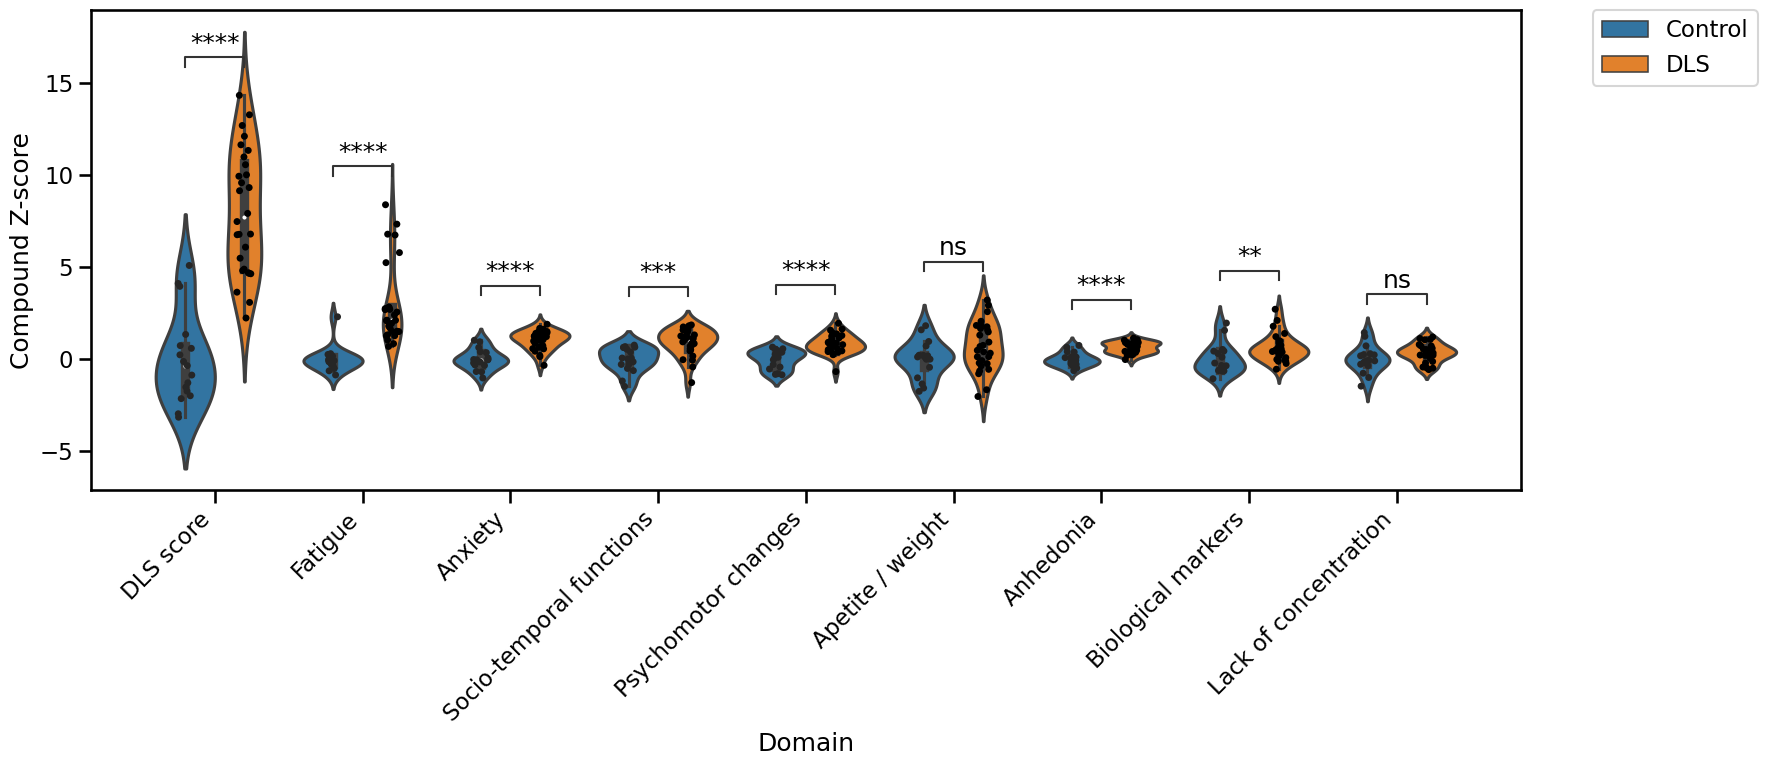

In [63]:
domain_scores.to_csv("../DLS_data/Results/DLS_domain_scores.csv")
domains_melted = domain_scores.melt(
    id_vars=["Sample name", "Condition"],
    var_name="Domain",
    value_name="Score"
)

# Compute mean scores per domain and condition
domain_means = domains_melted.groupby(["Domain", "Condition"])["Score"].mean().unstack()
domain_means["Effect Size"] = abs(domain_means["DLS"] - domain_means["Control"])

# Sort domains by effect size
sorted_domains = domain_means.sort_values("Effect Size", ascending=False).index.tolist()
domains_melted["Domain"] = pd.Categorical(domains_melted["Domain"], categories=sorted_domains, ordered=True)

plt.figure(figsize=(18, 8), dpi=100)

ax = sns.violinplot(data=domains_melted.sort_values(["Condition", "Score"]), x="Domain", y='Score', hue="Condition")
sns.stripplot(data=domains_melted.sort_values(["Condition", "Score"]), x="Domain", y='Score', hue="Condition", color="black", dodge=True)

# Remove second legend
handles, labels = ax.get_legend_handles_labels()

# Rotate X labels
plt.xticks(rotation=45, ha="right")

# Add statistical annotations
domain_pairs = []
for domain in domains_melted.Domain.unique():
    domain_pairs.append([(domain, "DLS"), (domain, "Control")])

annotator = Annotator(
    pairs=domain_pairs,
    data=domains_melted.sort_values(["Condition", "Score"]),
    x="Domain", 
    y="Score", 
    hue="Condition",
    verbose=1,
    ax=plt.gca()
)
annotator.configure(
    test="Mann-Whitney",
    comparisons_correction="fdr_bh",
)
annotator.apply_and_annotate()

plt.ylabel("Compound Z-score")
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("DLS_domain_scores_truncated.pdf")
plt.show()